In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import bootstrap
import pandahouse as ph

import requests
from urllib.parse import urlencode

%matplotlib inline

In [2]:
# ссылка на необходимые для работы файлы
groups_data_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
active_studs_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
groups_add_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

# Задание 1. Проанализировать итоги эксперимента по внедрению новой механики оплаты услуг на сайте

В ходе эксперимента с целевой группой (B) была внедрена новая система оплаты услуг на сайте, в то время как у контрольной группы (A) оставалась текущая базовая система

In [3]:
# считаем входные данные по API 
# функция для считывания данных по API
def get_data(public_key, sep):
    base_url ='https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return (pd.read_csv(download_url, sep=sep))

In [4]:
groups_data = get_data(public_key=groups_data_key,sep=';')
active_studs = get_data(public_key=active_studs_key,sep = ';')
checks = get_data(public_key=checks_key,sep = ';')

In [5]:
# изучим данные
print(f'В контрольной и целевой группах числится {groups_data.shape[0]} пользователей, из которых \
    {active_studs.shape[0]} зашли на сайт в дни проведения эксперимента \
    и лишь {checks.shape[0]} совершили целевое действие')

В контрольной и целевой группах числится 74484 пользователей, из которых 8341 зашли на сайт в дни проведения эксперимента и лишь 541 совершили целевое действие


In [6]:
# доля пользователей в контрольной и целевой группах
np.round(groups_data.grp.value_counts(normalize=True).mul(100),2)

B    80.3
A    19.7
Name: grp, dtype: float64

In [7]:
# объединим данные в один датафрейм
df = groups_data.merge(active_studs.student_id, left_on = groups_data.id, right_on=active_studs.student_id, 
                       how='left').drop('key_0', axis=1)

In [8]:
df = df.merge(checks.rev,left_on = df.id, right_on= checks.student_id, how='left').drop('key_0', axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74484 entries, 0 to 74483
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          74484 non-null  int64  
 1   grp         74484 non-null  object 
 2   student_id  8328 non-null   float64
 3   rev         540 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.8+ MB


In [10]:
# данный пользователь не принадлежит к контрольной / целевой группе
checks[checks.student_id.isin(df.id)==False]

,student_id,rev
540,5740903,1900.0


In [11]:
# доля пользователей по группам, которые зашли на сайт в дни проведения эксперимента: структура также сохраняется
np.round(df[df.student_id>0].grp.value_counts(normalize=True).mul(100),2)

B    81.57
A    18.43
Name: grp, dtype: float64

### Гипотеза 1: изменение соотношения количества покупок на сайте

In [12]:
# создадим переменные, которые отвечают за покупку на сайте и активность в дни проведения эксперимента
df['is_pay']= df.rev.apply(lambda x: 1 if x>0 else 0)
df['is_active'] = df.student_id.apply(lambda x: 1 if x>0 else 0)

Посмотрим на кросстабуляцию:

In [13]:
pd.crosstab(df[df.is_active==1].grp, df[df.is_active==1].is_pay)

is_pay,0,1
grp,,
A,1457,78
B,6480,313


Проверим, повлияла ли новая методика оплаты на количество покупок на сайте

Поскольку наличие оплаты представляет собой категориальную переменную (пользователь совершил оплату или нет), мы будем использовать критерий хи-квадрат для проведения анализа. Сформулируем наши гипотезы следующим образом: Нулевая гипотеза (H0) утверждает, что новый метод оплаты не оказывает влияния на факт совершения покупки на сайте, в то время как альтернативная гипотеза (H1) предполагает, что новый метод оплаты влияет на решение пользователя о совершении покупки на сайте.

In [14]:
# воспользуемся функцией chi2_contingency из библиотеки scipy.stats
alpha = 0.05 # критерий значимости
if st.chi2_contingency(pd.crosstab(df[df.is_active==1].grp, df[df.is_active==1].is_pay))[1]> alpha:
    print('У нас нет оснований отвергнуть нулевую гипотезу')
else:
    print('Мы отвергаем нулевую гипотезу')

У нас нет оснований отвергнуть нулевую гипотезу


# Ответ

У нас недостаточно данных для опровержения нулевой гипотезы, поэтому мы не можем утверждать, что новый метод оплаты влияет на изменение объема покупок на сайте.

Далее посмотрим на метрики:

In [15]:
data_metrics = df.groupby('grp', as_index=False)\
    .agg({'id':'count',
          'is_active':'sum',
          'is_pay':'sum',
          'rev':'sum'})\
    .rename(columns={'id':'cnt_id','rev':'revenue'})
data_metrics['CR'] = (data_metrics.is_pay/data_metrics.cnt_id).mul(100)
data_metrics['active_CR'] = (data_metrics.is_pay/data_metrics.is_active).mul(100)
data_metrics['ARPAU']= (data_metrics.revenue/data_metrics.is_active)
data_metrics['ARPPU']= (data_metrics.revenue/data_metrics.is_pay) 
data_metrics

,grp,cnt_id,is_active,is_pay,revenue,CR,active_CR,ARPAU,ARPPU
0,A,14671,1535,107,92096.0000,0.729330,6.970684,59.997394,860.710280
1,B,59813,6793,433,479330.0036,0.723923,6.374209,70.562344,1106.997699


Мы замечаем, что конверсия (CR) существенно не изменилась независимо от группы, при этом средний чек в целевой группе выше

### Гипотеза 2: изменение среднего чека (AOV) покупки на сайте

Давайте проанализируем распределение покупок среди пользователей и замечаем, что оно далеко от нормального. В контрольной группе A, где используется базовая механика, явно видно, что средний чек покупки ниже, чем в целевой группе B с новым методом оплаты

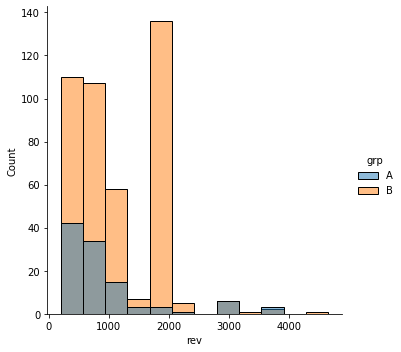

In [16]:
sns.displot(data = df[df.is_pay==1], x='rev', hue = 'grp')

Для вычисления среднего чека (AOV) используется количество заказов, но в данном примере не указано, сколько покупок приходится на одного пользователя. У нас есть сумма для каждого уникального пользователя (id), и в данном контексте AOV равен ARPPU (средний доход на пользователя). Поэтому мы предположим, что каждый из наших пользователей совершил только одну покупку, и в связи с этим мы рассмотрим изменение в ARPPU

### Гипотеза 3: изменение ARPPU

В этом случае мы применим метод Bootstrap: создадим 95% доверительный интервал (уровень значимости alpha=5%) для разницы метрик между группами. t - это статистика теста. Сформулируем наши гипотезы: H0 - t равно 0, H1 - t не равно 0

In [17]:
def get_percentile_ci(bootstrap_stats, alpha):
    # строим доверительный интервал
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def check_bootsrtap(a, b, n_iter, alpha):
    
    # посчитаем стоимость и количество покупок в группах
    df_a = np.array([[sum(values), len(values)] for values in a.items()])
    df_b = np.array([[sum(values), len(values)] for values in b.items()])
    
    # сгенирируем индексы для выбора подмножества данных
    len_a = len(a)
    len_b = len(b)
    indexes_a = np.random.choice(np.arange(len_a), size=(n_iter, len_a), replace=True)
    indexes_b = np.random.choice(np.arange(len_b), size=(n_iter, len_b), replace=True)
    
    bootstrap_stats = []
    
    for idx_a, idx_b in zip(indexes_a, indexes_b):
        bootstrap_df_a = df_a[idx_a]
        bootstrap_df_b = df_b[idx_b]
        
    # считаем разницу метрик
        bootstrap_stat = (bootstrap_df_b[:, 0].sum() / bootstrap_df_b[:, 1].sum()
                - bootstrap_df_a[:, 0].sum() / bootstrap_df_a[:, 1].sum())
        bootstrap_stats.append(bootstrap_stat)
        
    # строим доверительный интервал и оценим значимость отличий
    ci = get_percentile_ci(bootstrap_stats, alpha)
    has_effect = not (ci[0] < 0 < ci[1])
    return has_effect

In [18]:
alpha = 0.05
n_iter = 1000
a = df[(df.grp=='A') & (df.is_pay==1)].rev
b = df[(df.grp=='B') & (df.is_pay==1)].rev

In [19]:
effects = []
for _ in range(1000):
    has_effect = check_bootsrtap(a, b, n_iter, alpha)
    effects.append(has_effect)

In [20]:
# ошибка первого рода - ситуация, когда отвергнута верная нулевая гипотеза
error_rate = np.mean(np.array(effects) == 1)
print(f'Доля ошибок первого рода: {error_rate:0.3f}')

Доля ошибок первого рода: 0.000


# Ответ

Видим, что в нашем случае отличия статистически значимы - > Таким образом, ARPPU действительно увеличился

# Задание 2. Запросы в SQL

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [21]:
# подключаемся к базе данных
connection_default={'database':'default',
            'host':'https://clickhouse.lab.karpov.courses',
            'user':'student',
            'password' : 'dpo_python_2020'}

In [22]:
# посмотрим за какой период у нас есть данные
query_date ="""
SELECT toStartOfMonth(max(Date(timest))) as current_month
    FROM default.peas 
"""

In [23]:
current_month = ph.read_clickhouse(query=query_date, connection=connection_default)
current_month

,current_month
0,2021-10-01


In [24]:
# сформируем запрос о количестве усердных студентов вне зависимости от курса за текущий месяц

query_students = """
SELECT COUNT(st_id)  
FROM
    (SELECT st_id, toStartOfMonth(timest) as month, sum(correct) as correct_task
    FROM default.peas 
    GROUP BY st_id, month
    HAVING toStartOfMonth(max(timest))=month)
WHERE correct_task >= 20
"""

In [25]:
# количество усердных студентов
ph.read_clickhouse(query=query_students, connection=connection_default)

,count(st_id)
0,136


В одном запросе требуется извлечь следующую информацию о группах пользователей:

ARPU (средний доход на пользователя)
ARPAU (средний доход на активного пользователя)
Конверсия в покупку (CR)
Конверсия активного пользователя в покупку
Конверсия пользователя, активного в математике (subject = "Math"), в покупку курса по математике.
ARPU рассчитывается относительно всех пользователей, входящих в группы. Активным считается пользователь, который за все время правильно решил более 10 задач в любых дисциплинах. Активным по математике считается пользователь, который за все время правильно решил 2 или более задачи по математике.

In [26]:
query_metrics = """
with empt as (SELECT l.st_id as st_id, l.subject as subject, r.test_grp as test_grp, count(l.correct) as number_task, sum(l.correct) as is_correct, min(z.money) as money, if (money>0,1,0) as is_pay, if (is_correct > 10,1,0) as is_active
FROM default.peas as l
LEFT JOIN (
    SELECT st_id, test_grp
    FROM default.studs
    ) as r
ON l.st_id = r.st_id
LEFT JOIN (
    SELECT st_id, subject, money 
    FROM default.final_project_check) as z
ON l.st_id=z.st_id and l.subject = z.subject
GROUP BY st_id, subject, test_grp)

SELECT test_grp,
    round(sum(money)/uniqExact(st_id),2) as ARPU,
    round(sumIf(money, is_active=1)/uniqExactIf(st_id,is_active=1),2) as ARPAU,
    round(uniqExactIf(st_id,is_pay=1)/uniqExact(st_id)*100,2) as CR,
    round(uniqExactIf(st_id, is_pay=1 AND is_active=1)/uniqExactIf(st_id, is_active=1)*100,2) as active_CR,
    round(uniqExactIf(st_id, is_pay=1 AND subject='Math' AND is_correct>=2)/uniqExactIf(st_id, subject='Math' AND is_correct>=2)*100,2) as active_math_CR
FROM empt
GROUP BY test_grp
"""

In [27]:
metrics = ph.read_clickhouse(query=query_metrics, connection=connection_default)
metrics

,test_grp,ARPU,ARPAU,CR,active_CR,active_math_CR
0,control,4121.21,3898.31,4.85,5.08,6.12
1,pilot,7902.10,8131.87,8.39,8.79,9.52


# Задание 3.

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [28]:
groups_add_data = get_data(groups_add_key, sep=',')

In [29]:
groups_add_data.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [30]:
def new_calculation_metrics(add_data):
    new_groups_data = pd.concat([groups_data,add_data])
    df = new_groups_data.merge(active_studs.student_id, left_on = new_groups_data.id, right_on=active_studs.student_id, how='left').drop('key_0', axis=1)
    df = df.merge(checks.rev,left_on = df.id, right_on= checks.student_id, how='left').drop('key_0', axis=1)
    df['is_pay']= df.rev.apply(lambda x: 1 if x>0 else 0)
    df['is_active'] = df.student_id.apply(lambda x: 1 if x>0 else 0)
    new_data_metrics = df.groupby('grp', as_index=False)\
    .agg({'id':'count',
          'is_active':'sum',
          'is_pay':'sum',
          'rev':'sum'})\
    .rename(columns={'id':'cnt_id','rev':'revenue'})
    new_data_metrics['CR'] = (new_data_metrics.is_pay/new_data_metrics.cnt_id).mul(100)
    new_data_metrics['active_CR'] = (new_data_metrics.is_pay/new_data_metrics.is_active).mul(100)
    new_data_metrics['ARPAU']= (new_data_metrics.revenue/new_data_metrics.is_active)
    new_data_metrics['ARPPU']= (new_data_metrics.revenue/new_data_metrics.is_pay)
    return (new_data_metrics)

In [31]:
new_metrics = new_calculation_metrics(groups_add_data)

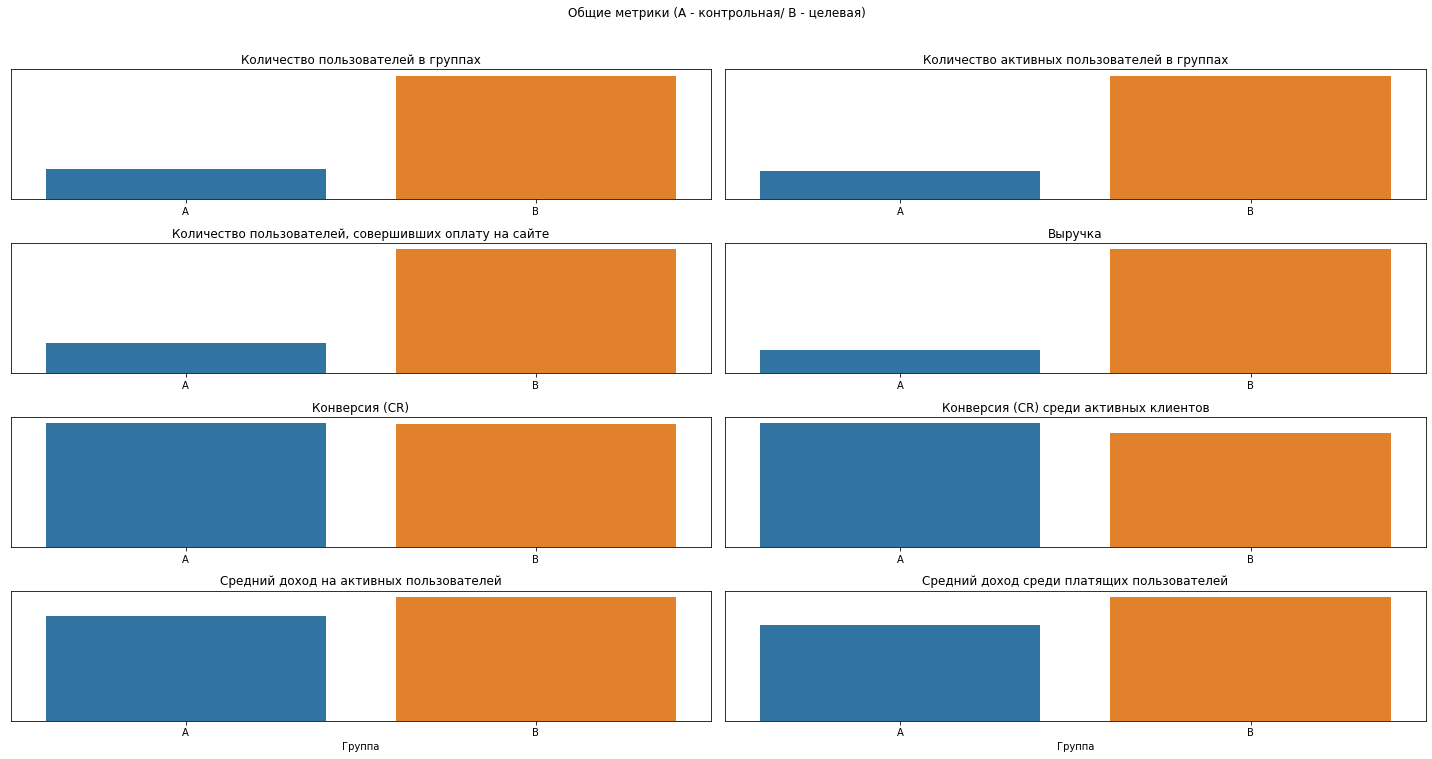

In [32]:
fig, axes = plt.subplots(4,2,figsize=(20, 10))
sns.barplot(x='grp', y='cnt_id', data = new_metrics, ax=axes[0,0]).set(title = 'Количество пользователей в группах',facecolor='white', ylabel='',xlabel='',yticks=[])
sns.barplot(x='grp', y='is_active', data = new_metrics, ax=axes[0,1]).set(title = 'Количество активных пользователей в группах',facecolor='white', ylabel='',xlabel='',yticks=[])
sns.barplot(x='grp', y='is_pay', data = new_metrics, ax=axes[1,0]).set(title = 'Количество пользователей, совершивших оплату на сайте',facecolor='white', ylabel='',xlabel='',yticks=[])
sns.barplot(x='grp', y='revenue', data = new_metrics, ax=axes[1,1]).set(title = 'Выручка',facecolor='white', ylabel='',xlabel='',yticks=[])
sns.barplot(x='grp', y='CR', data = new_metrics, ax=axes[2,0]).set(title = 'Конверсия (CR)',facecolor='white', ylabel='',xlabel='',yticks=[])
sns.barplot(x='grp', y='active_CR', data = new_metrics, ax=axes[2,1]).set(title = 'Конверсия (CR) среди активных клиентов',facecolor='white', ylabel='',xlabel='',yticks=[])
sns.barplot(x='grp', y='ARPAU', data = new_metrics, ax=axes[3,0]).set(title = 'Средний доход на активных пользователей',facecolor='white', ylabel='', xlabel='Группа',yticks=[])
sns.barplot(x='grp', y='ARPPU', data = new_metrics, ax=axes[3,1]).set(title = 'Средний доход среди платящих пользователей',facecolor='white', ylabel='', xlabel='Группа',yticks=[])

    
fig.suptitle('Общие метрики (A - контрольная/ B - целевая)', fontsize=12, x = 0.5, y = 1.05)
plt.tight_layout()
plt.show()